In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'


In [3]:
df = pd.read_excel(raw_dir+'ICF_extractions_211223.xlsx', index_col = [0])

In [4]:
df.groupby('Index').size()

Index
1     12
2      4
3     17
4     14
5     20
      ..
78     6
79     2
80    18
81     9
82     5
Length: 82, dtype: int64

June-October extraction set has extracted 82 read-across examples

In [5]:
df.shape

(735, 53)

In [6]:
df.Index.nunique()

82

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 735 entries, 0 to 178
Data columns (total 53 columns):
 #   Column                                                                                                                               Non-Null Count  Dtype  
---  ------                                                                                                                               --------------  -----  
 0   Status                                                                                                                               735 non-null    object 
 1   Index                                                                                                                                735 non-null    int64  
 2   Substance Name in Assessment                                                                                                         735 non-null    object 
 3   Substance Number in Assessment                                                  

In [8]:
df['Decision Context Purpose (e.g., regulatory, hazard screening, risk assessment, REACH, TSCA, test order, framework validation, etc.)'].unique()

array(['Case study to clarify regulatory acceptance and improve OECD guidance',
       'Read-across framework validation for risk assessment',
       'Case study to demonstrate read-across attempted for registration under EU REACH and accepted under OECD HPV programme',
       'Case study to illustrate issues with read-across and improve OECD guidance',
       'Case study to suggest key elements for read-across that may be used for regulatory purposes',
       'Case study for risk assessment with strategy designed to pass the ECHA RAAF',
       'Case study to illustrate issues with read-across and help develop OECD guidance',
       'Risk assessment',
       'Case study of hazard characterization for screening assessment under the Japanese Chemical Substances of Control Law (CSCL)',
       'Screening assessment under Japanese Chemicals Substances Control Law (CSCL)',
       'REACH registration',
       'Case study to illustrate issues associated with predicting subchronic effects (not 

In [9]:
decision_context = {'Case study to clarify regulatory acceptance and improve OECD guidance' : 'technical_guidance',
       'Read-across framework validation for risk assessment' : 'technical_guidance',
       'Case study to demonstrate read-across attempted for registration under EU REACH and accepted under OECD HPV programme' : 'regulatory_purpose',
       'Case study to illustrate issues with read-across and improve OECD guidance' : 'technical_guidance',
       'Case study to suggest key elements for read-across that may be used for regulatory purposes' :'technical_guidance',
       'Case study for risk assessment with strategy designed to pass the ECHA RAAF':'technical_guidance',
       'Case study to illustrate issues with read-across and help develop OECD guidance':'technical_guidance',
       'Risk assessment':'regulatory_purpose',
       'Case study of hazard characterization for screening assessment under the Japanese Chemical Substances of Control Law (CSCL)':'regulatory_purpose',
       'Screening assessment under Japanese Chemicals Substances Control Law (CSCL)':'regulatory_purpose',
       'REACH registration':'regulatory_purpose',
       'Case study to illustrate issues associated with predicting subchronic effects (not intended for any regulatory purposes)':'technical_guidance',
       'Case study to demonstrate how NAMs can support read-across for REACH registration' : 'NAMs',
       'Case study to demonstrate application of an AOP-based testing strategy for read across (under the domain of the EFSA)' : 'NAMs',
       "Hazard characterization; Groupings Initiative of Canada's Chemical's Management Plan (CMP)":'regulatory_purpose',
       'Case study to demonstrate how NAMs can support read-across': 'NAMs',
       'Calculate permitted daily exposure under the European Medicine Agency (EMA) guideline':'regulatory_purpose',
       'Case study to improve guidance for read-across':'technical_guidance',
       'Case study to demonstrate how metabolomics data can be used to improve chemical grouping for read-across predictions; to compare the predicted outcome with actual study outcome required by REACH' :'NAMs',
       'Case study to demonstrate how metabolomics data can be used to support read-across predictions for REACH registration' : 'NAMs',
       'Hazard assessment; OECD HPV Programme':'regulatory_purpose',
       "Screening risk assessment/risk characterization; Canada's Chemical's Management Plan (CMP)": 'regulatory_purpose'}

In [10]:
len(decision_context)

22

There are 22 unique decisions context which when aggregated by NAMs, technical guidance or regulatory purposes finds of the 82 examples, 68 capture regulatory purposes and the remainder are relatively evenly split between efforts to improve guidance or evaluate the utility of NAMs to substance read-across.

In [11]:
df['decision_context'] = df['Decision Context Purpose (e.g., regulatory, hazard screening, risk assessment, REACH, TSCA, test order, framework validation, etc.)'].replace(decision_context)

In [12]:
#df.decision_context.value_counts().plot.barh()

In [13]:
df.drop_duplicates(subset=['Index', 'decision_context'])['decision_context'].value_counts(dropna = False)

regulatory_purpose    68
technical_guidance     8
NAMs                   6
NaN                    1
Name: decision_context, dtype: int64

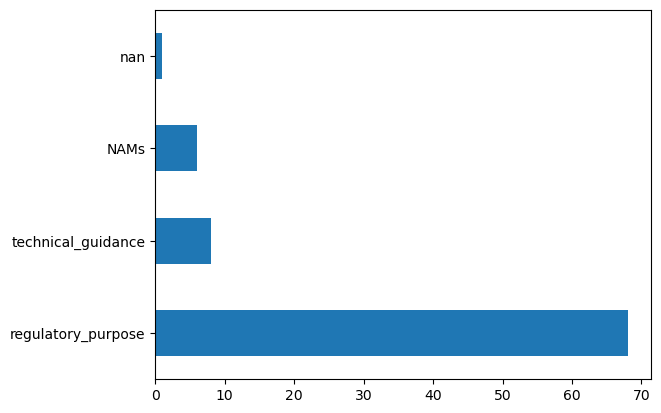

In [14]:
df.drop_duplicates(subset=['Index', 'decision_context'])['decision_context'].value_counts(dropna = False).plot.barh();


In [15]:
df.drop_duplicates(subset=['Index', 'decision_context'])['decision_context'].value_counts(dropna = False, normalize = True)

regulatory_purpose    0.819277
technical_guidance    0.096386
NAMs                  0.072289
NaN                   0.012048
Name: decision_context, dtype: float64

In [16]:
df.drop_duplicates(subset=['Index', 'decision_context'])['decision_context'].value_counts(dropna = False, normalize = False)

regulatory_purpose    68
technical_guidance     8
NAMs                   6
NaN                    1
Name: decision_context, dtype: int64

In [17]:
df['Source (e.g. OECD IATA case study,  U.S. EPA PPRTV, journal article, primary author, etc.)'].unique()

array(['OECD IATA case study', 'Journal article',
       'OECD IATA case study; Journal article (https://doi.org/10.1016/j.comtox.2017.02.005)',
       'OECD IATA case study; Journal article (https://doi.org/10.1016/j.comtox.2018.05.001)',
       'OECD IATA case study; Journal article (https://doi.org/10.1016/j.comtox.2017.02.002)',
       'US EPA PPRTV',
       'OECD IATA case study; Journal article (https://doi.org/10.1016/j.yrtph.2014.10.011)',
       'OECD IATA case study (developed by EU ToxRisk project [BIAC])',
       'OECD SIDS',
       'Health Canada screening assessment for the Challenge',
       'ECETOC case study'], dtype=object)

In [18]:
source_dict = {'OECD IATA case study' : 'OECD IATA case study', 'Journal article': 'Journal article',
       "OECD IATA case study; Journal article (https://doi.org/10.1016/j.comtox.2017.02.005)" : 'OECD IATA case study' ,
       "OECD IATA case study; Journal article (https://doi.org/10.1016/j.comtox.2018.05.001)": 'OECD IATA case study' ,
       "OECD IATA case study; Journal article (https://doi.org/10.1016/j.comtox.2017.02.002)": 'OECD IATA case study' ,
       'US EPA PPRTV': 'US EPA PPRTV',
       "OECD IATA case study; Journal article (https://doi.org/10.1016/j.yrtph.2014.10.011)" : 'OECD IATA case study',
       "OECD IATA case study (developed by EU ToxRisk project [BIAC])": 'OECD IATA case study',
       'OECD SIDS': 'OECD SIDS',
       'Health Canada screening assessment for the Challenge' : 'Health Canada case study',
       'ECETOC case study': 'ECETOC case study'}

In [19]:
df['source'] = df['Source (e.g. OECD IATA case study,  U.S. EPA PPRTV, journal article, primary author, etc.)'].replace(source_dict)

<Axes: >

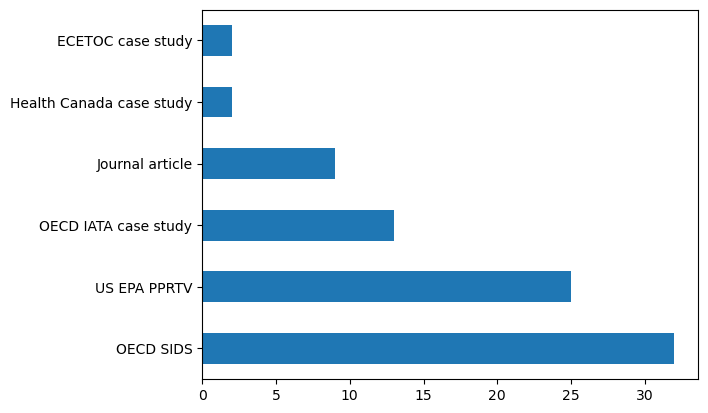

In [20]:
df.drop_duplicates(subset=['Index', 'source'])['source'].value_counts(dropna = False).plot.barh()

In [21]:
df.drop_duplicates(subset=['Index', 'source'])['source'].value_counts(dropna = False, normalize = True)

OECD SIDS                   0.385542
US EPA PPRTV                0.301205
OECD IATA case study        0.156627
Journal article             0.108434
Health Canada case study    0.024096
ECETOC case study           0.024096
Name: source, dtype: float64

In [22]:
df.drop_duplicates(subset=['Index', 'source'])['source'].value_counts(dropna = False)

OECD SIDS                   32
US EPA PPRTV                25
OECD IATA case study        13
Journal article              9
Health Canada case study     2
ECETOC case study            2
Name: source, dtype: int64

The balance of decision contexts perhaps is not unsurprising given the origin of the examples extracted, ~25 (30%) examples are taken from the US EPA PPRTV activity,  38% were OECD SIDS examples, 15% were OECD IATA case studies, 10% from journal articles with the remainder a couple of examples from ECETOC and Health Canada.

In [23]:
#df['Approach \n(Analogue or Category)']
df.drop_duplicates(subset=['Index', 'Approach \n(Analogue or Category)'])['Approach \n(Analogue or Category)'].value_counts(dropna = False, normalize = True)

Category             0.554217
Analogue             0.361446
Category/Analogue    0.072289
NaN                  0.012048
Name: Approach \n(Analogue or Category), dtype: float64

If we look at the approaches used - there is a bias towards category analogues with 55% examples being categories and 36% being analogue approaches.

In [34]:
#df.groupby(['source'])['Approach \n(Analogue or Category)'].value_counts(normalize = True)

|Source  | Approach | Proportion of cases|
|:-:|:-:|:-:|
|ECETOC case study |       Category |                            1.000000|
|Health Canada case study | Analogue   |                          1.000000|
|Journal article       |    Category     |                        0.916667|
 |                         |Analogue                    |         0.083333|
|OECD IATA case study|      Category      |                       0.989418|
 |                         |Analogue                         |    0.010582|
|OECD SIDS  |               Category         |                    0.836538|
  |                      |  Category/Analogue       |            0.163462|
|US EPA PPRTV      |        Analogue          |                   1.000000|

If we look at the approaches with respect to the source - all of the EPA PPRTV cases rely on an analogue approaches, whereas in general over 90% of all the OECD IATA case studies, SIDS dossiers and Journal articles have relied on a category approach.

In [24]:
df.DTXSID.nunique()

497

In [25]:
df.SMILES.nunique()

468

In [28]:
df[df['SMILES'].isnull()]['Index'].nunique()

11

In [58]:
df[df['SMILES'].isnull()].head()#["Source (e.g. OECD IATA case study,  U.S. EPA PPRTV, journal article, primary author, etc.)"].unique()

,Status,Index,Substance Name in Assessment,Substance Number in Assessment,Substance Role,Read-Across Assessment Title,Year of Assessment,Link to Assessment,"Source (e.g. OECD IATA case study, U.S. EPA PPRTV, journal article, primary author, etc.)","Decision Context Purpose (e.g., regulatory, hazard screening, risk assessment, REACH, TSCA, test order, framework validation, etc.)",...,Citation for Toxicity Value,Predicted Toxicity Type,Toxicological Endpoint Predicted by Read-Across,Predicted Endpoint Value,Predicted Endpoint Value Units,Method or Calculation Used to Derive Target Chemical Endpoint Value,Authors' Rationale for Choosing the Analogues/Category Justification,Analogue Evidence Stream,decision_context,source
337,QC done,40,Octyl 3-[3-(benzotriazol-2-yl)-5-tert-butyl-4-...,10,Target,CASE STUDY ON THE USE OF AN INTEGRATED APPROAC...,2017.0,http://www.oecd.org/officialdocuments/displayd...,OECD IATA case study,Case study of hazard characterization for scre...,...,NaN,repeated-dose oral,LOAEL,64,mg/kg/day,The LOAEL for member 9 (50 mg/kg/day or 0.141 ...,The category was defined as substances with th...,Structural_CHRIP_OECD-Toolbox_common-phenolic-...,regulatory_purpose,OECD IATA case study
341,QC done,41,"Benzenamine, ar-nonyl-N-phenyl- (UVCB)",Subgroup 1: 2,Source Analogue,CASE STUDY ON THE USE OF INTEGRATED APPROACHES...,2016.0,http://www.oecd.org/officialdocuments/displayd...,OECD IATA case study,Hazard characterization; Groupings Initiative ...,...,NaN,NaN,NaN,NaN,NaN,NaN,The category was defined as substituted diphen...,Structural_OECD-Toolbox_ diphenylamine-core_mo...,regulatory_purpose,OECD IATA case study
342,QC done,41,"Benzenamine, N-phenyl-, reaction products with...",Subgroup 2: 1,Category Member,CASE STUDY ON THE USE OF INTEGRATED APPROACHES...,2016.0,http://www.oecd.org/officialdocuments/displayd...,OECD IATA case study,Hazard characterization; Groupings Initiative ...,...,NaN,NaN,NaN,NaN,NaN,NaN,The category was defined as substituted diphen...,Structural_OECD-Toolbox_ diphenylamine-core_va...,regulatory_purpose,OECD IATA case study
343,QC done,41,"Benzenamine, N-phenyl-, reaction products with...",Subgroup 2: 2,Category Member,CASE STUDY ON THE USE OF INTEGRATED APPROACHES...,2016.0,http://www.oecd.org/officialdocuments/displayd...,OECD IATA case study,Hazard characterization; Groupings Initiative ...,...,NaN,NaN,NaN,NaN,NaN,NaN,The category was defined as substituted diphen...,Structural_OECD-Toolbox_ diphenylamine-core_va...,regulatory_purpose,OECD IATA case study
344,QC done,41,"Benzenamine, ar-octyl-N-(octylphenyl)- (UVCB)",Subgroup 2: 3,Target,CASE STUDY ON THE USE OF INTEGRATED APPROACHES...,2016.0,http://www.oecd.org/officialdocuments/displayd...,OECD IATA case study,Hazard characterization; Groupings Initiative ...,...,NaN,repeated-dose oral,LOAEL,100,mg/kg/day,Subgroup 2: A NOAEL was not determined for the...,The category was defined as substituted diphen...,Structural_OECD-Toolbox_ diphenylamine-core_va...,regulatory_purpose,OECD IATA case study


In [40]:
#df[df['SMILES'].isnull()]

In [62]:
df1 = df.drop_duplicates(subset = ['DTXSID']) 



In [82]:
df1.shape

(497, 55)

In [84]:
df1.to_csv(interim_dir+'icf_processed_110424.csv')

In [38]:
df2 = df1[df1['SMILES'].notnull()]

In [39]:
my_inchi = {}
for x,y in zip(df2['DTXSID'], df2['SMILES']):
    my_inchi[x] = Chem.MolToInchiKey(Chem.MolFromSmiles(y))

In [40]:
#my_inchi

Explore chemical classes using the Classify ontology by Wishart

In [41]:
import requests
import time

In [42]:
groups = ['kingdom','superclass','class','subclass']

classy_data = []
for idx, smi in my_inchi.items():
    classyfire = [smi]

    response = requests.get(f'http://classyfire.wishartlab.com/entities/{smi}.json').json()
    if 'code' in response:
        time.sleep(5)
        response = requests.get(f'http://classyfire.wishartlab.com/entities/{smi}.json').json()
        try:
            for group in groups:
                if response[group] is not None:        
                    category_name = response[group]['name']
                    classyfire.append(category_name)
                else:
                    classyfire.append('N/a')
        except:
            classyfire.append('x')
    classy_data.append(classyfire)

In [43]:
classify_df = pd.concat([pd.DataFrame(list(my_inchi.items()), columns = ['dtxsid', 'inchi-key_']), pd.DataFrame(classy_data, columns = ['inchi-key', 'kingdom','superclass','class','subclass'])], axis = 1)

In [44]:
classify_df['kingdom'] = classify_df['kingdom'].replace('x', None)

In [45]:
classify_df['subclass'] = classify_df['subclass'].replace('N/a', None)

In [49]:
classify_df['class'].value_counts(dropna = False, normalize = True).head()

Benzene and substituted derivatives    0.256410
Fatty Acyls                            0.141026
Organooxygen compounds                 0.121795
Carboxylic acids and derivatives       0.119658
None                                   0.083333
Name: class, dtype: float64

In [52]:
classify_df

,dtxsid,inchi-key_,inchi-key,kingdom,superclass,class,subclass
0,DTXSID4020298,MVPPADPHJFYWMZ-UHFFFAOYSA-N,MVPPADPHJFYWMZ-UHFFFAOYSA-N,None,None,None,None
1,DTXSID1020431,OCJBOOLMMGQPQU-UHFFFAOYSA-N,OCJBOOLMMGQPQU-UHFFFAOYSA-N,None,None,None,None
2,DTXSID6020430,RFFLAFLAYFXFSW-UHFFFAOYSA-N,RFFLAFLAYFXFSW-UHFFFAOYSA-N,None,None,None,None
3,DTXSID6022056,ZPQOPVIELGIULI-UHFFFAOYSA-N,ZPQOPVIELGIULI-UHFFFAOYSA-N,None,None,None,None
4,DTXSID0021965,PBKONEOXTCPAFI-UHFFFAOYSA-N,PBKONEOXTCPAFI-UHFFFAOYSA-N,None,None,None,None
...,...,...,...,...,...,...,...
463,DTXSID3024366,ZMANZCXQSJIPKH-UHFFFAOYSA-N,ZMANZCXQSJIPKH-UHFFFAOYSA-N,Organic compounds,Organic nitrogen compounds,Organonitrogen compounds,Amines
464,DTXSID9026633,SVYKKECYCPFKGB-UHFFFAOYSA-N,SVYKKECYCPFKGB-UHFFFAOYSA-N,Organic compounds,Organic nitrogen compounds,Organonitrogen compounds,Cyclohexylamines
465,DTXSID4026761,XJRBAMWJDBPFIM-UHFFFAOYSA-N,XJRBAMWJDBPFIM-UHFFFAOYSA-N,Organic compounds,Organic oxygen compounds,Organooxygen compounds,None
466,DTXSID3029609,FJKIXWOMBXYWOQ-UHFFFAOYSA-N,FJKIXWOMBXYWOQ-UHFFFAOYSA-N,Organic compounds,Organic oxygen compounds,Organooxygen compounds,None


In [50]:
25+14+12+12

63

In [47]:
classify_df.to_csv(external_dir+'classify_oct_icf_rax.csv')

Functions to derive Morgan FP and Jaccard distance matrices as inputs for TSNE and hierarchical clustering

In [64]:
def mk_fp(df):

    '''
    Function to create a Morgan FP  of length 1024 and radius 3. Input file is expecting a dtxsid and smiles column in a df. 
    Expects dtxsid as identifier and smiles as SMILES.
    Returns df of index as dtxsid values and columns as 1024 morgan FP
    '''

    MOLS = dict(zip(df['DTXSID'], df['SMILES']))
    MOLS = {k:Chem.MolFromSmiles(v) for k,v in MOLS.items()}
    MOLS = {i:j for i,j in MOLS.items() if j}
    FP0 = pd.DataFrame([np.array(AllChem.GetMorganFingerprintAsBitVect(i,3,1024)) for i in MOLS.values()])
    FP0.index = MOLS.keys()
    FP0.columns = ['mrgn_%d'%i for i in FP0.columns]
    return FP0


In [65]:
def distance_matrix(df):
    '''
    Function to create a pairwise square distance matrix using the Jaccard index
    '''
    D_mgrn = pd.DataFrame(squareform(pdist(df, 'jaccard')), columns = df.index, index = df.index)

    return D_mgrn


In [66]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.cluster.hierarchy import inconsistent

In [67]:
my_index = {k:v for k,v in zip(df1[df1['SMILES'].notnull()]['DTXSID'], df1[df1['SMILES'].notnull() ]['Index'] )}


In [68]:
FP = mk_fp(df1[df1['SMILES'].notnull()])

In [69]:
D = distance_matrix(FP)

In [59]:
Zm = linkage(squareform(D), 'ward')

Exploring the chemical similarity across the dataset on the basis of Morgan FP

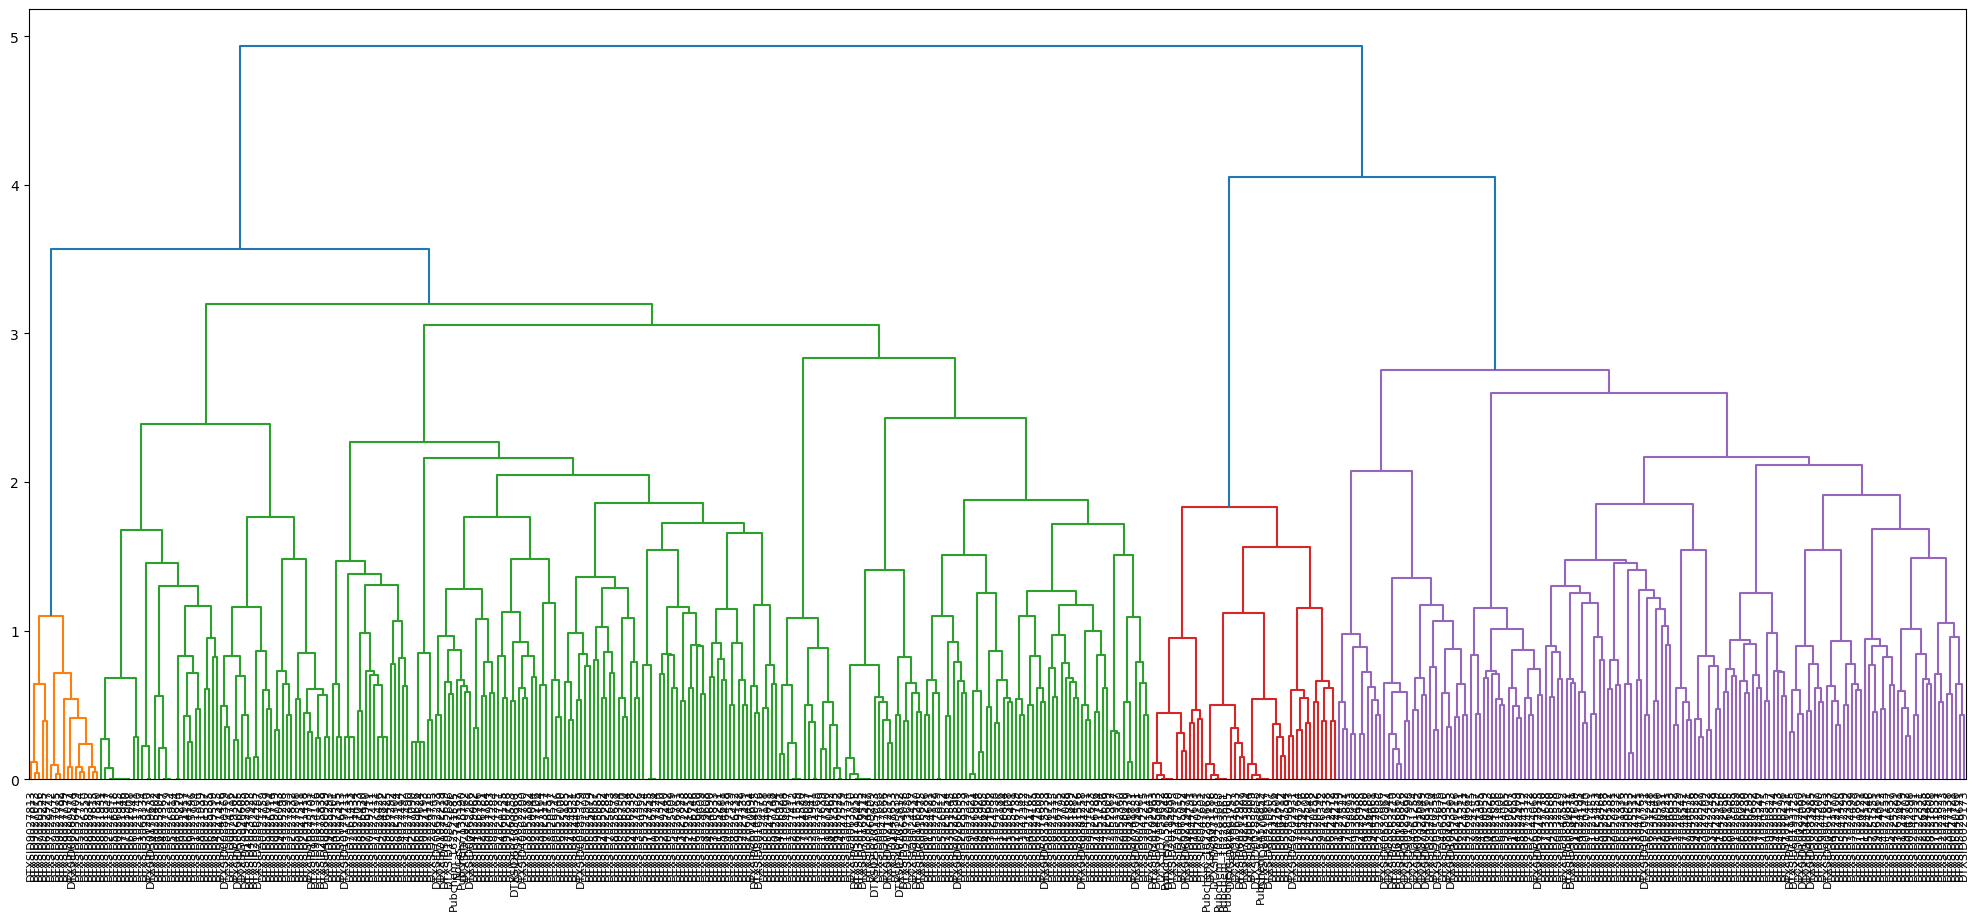

In [60]:
plt.figure(figsize=(25, 10))
dendrogram(
    Zm,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8., 
    labels = D.index# font size for the x axis labels
)
plt.show()

In [61]:
from sklearn.manifold import TSNE

In [62]:
FP_embedded = TSNE(n_components=2, learning_rate='auto',init='pca').fit_transform(FP)

In [88]:
tsne_df = pd.DataFrame(FP_embedded)
tsne_df.columns = ['X', 'Y']
tsne_df.index = FP.index

In [89]:
tsne_df = tsne_df.reset_index()

In [90]:
tsne_df['Index'] = tsne_df['index'].replace(my_index)

In [91]:
#tsne_df = tsne_df.set_index('index')


In [92]:
tsne_df.index.name = None
tsne_df

,index,X,Y,Index
0,DTXSID4020298,-16.148329,8.384173,1
1,DTXSID1020431,-17.616182,7.853879,1
2,DTXSID6020430,-15.054038,7.449122,1
3,DTXSID6022056,-16.739862,6.394609,1
4,DTXSID0021965,-18.552992,5.086170,1
...,...,...,...,...
463,DTXSID3024366,-1.386245,-2.702829,81
464,DTXSID9026633,-11.610102,-12.299802,81
465,DTXSID4026761,-5.715814,-9.692006,82
466,DTXSID3029609,-4.351632,-10.962162,82


In [93]:
tsne_df['Index_simple'] = tsne_df['Index'].apply(lambda x: 0 if x >30 else x)

In [77]:
tsne_df2 = tsne_df.set_index('index')

In [95]:
tsne_df2 = pd.concat([tsne_df.set_index('index'), classify_df.set_index('dtxsid')], axis = 1)

In [70]:
classify_dict = {k:v for k,v in zip(classify_df['dtxsid'], classify_df['class'])}


2D-TSNE for the dataset colour coded by Superclass designations from Classify where available

In [96]:
tsne_df2

,X,Y,Index,Index_simple,inchi-key_,inchi-key,kingdom,superclass,class,subclass
DTXSID4020298,-16.148329,8.384173,1,1,MVPPADPHJFYWMZ-UHFFFAOYSA-N,MVPPADPHJFYWMZ-UHFFFAOYSA-N,None,None,None,None
DTXSID1020431,-17.616182,7.853879,1,1,OCJBOOLMMGQPQU-UHFFFAOYSA-N,OCJBOOLMMGQPQU-UHFFFAOYSA-N,None,None,None,None
DTXSID6020430,-15.054038,7.449122,1,1,RFFLAFLAYFXFSW-UHFFFAOYSA-N,RFFLAFLAYFXFSW-UHFFFAOYSA-N,None,None,None,None
DTXSID6022056,-16.739862,6.394609,1,1,ZPQOPVIELGIULI-UHFFFAOYSA-N,ZPQOPVIELGIULI-UHFFFAOYSA-N,None,None,None,None
DTXSID0021965,-18.552992,5.086170,1,1,PBKONEOXTCPAFI-UHFFFAOYSA-N,PBKONEOXTCPAFI-UHFFFAOYSA-N,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...
DTXSID3024366,-1.386245,-2.702829,81,0,ZMANZCXQSJIPKH-UHFFFAOYSA-N,ZMANZCXQSJIPKH-UHFFFAOYSA-N,Organic compounds,Organic nitrogen compounds,Organonitrogen compounds,Amines
DTXSID9026633,-11.610102,-12.299802,81,0,SVYKKECYCPFKGB-UHFFFAOYSA-N,SVYKKECYCPFKGB-UHFFFAOYSA-N,Organic compounds,Organic nitrogen compounds,Organonitrogen compounds,Cyclohexylamines
DTXSID4026761,-5.715814,-9.692006,82,0,XJRBAMWJDBPFIM-UHFFFAOYSA-N,XJRBAMWJDBPFIM-UHFFFAOYSA-N,Organic compounds,Organic oxygen compounds,Organooxygen compounds,None
DTXSID3029609,-4.351632,-10.962162,82,0,FJKIXWOMBXYWOQ-UHFFFAOYSA-N,FJKIXWOMBXYWOQ-UHFFFAOYSA-N,Organic compounds,Organic oxygen compounds,Organooxygen compounds,None


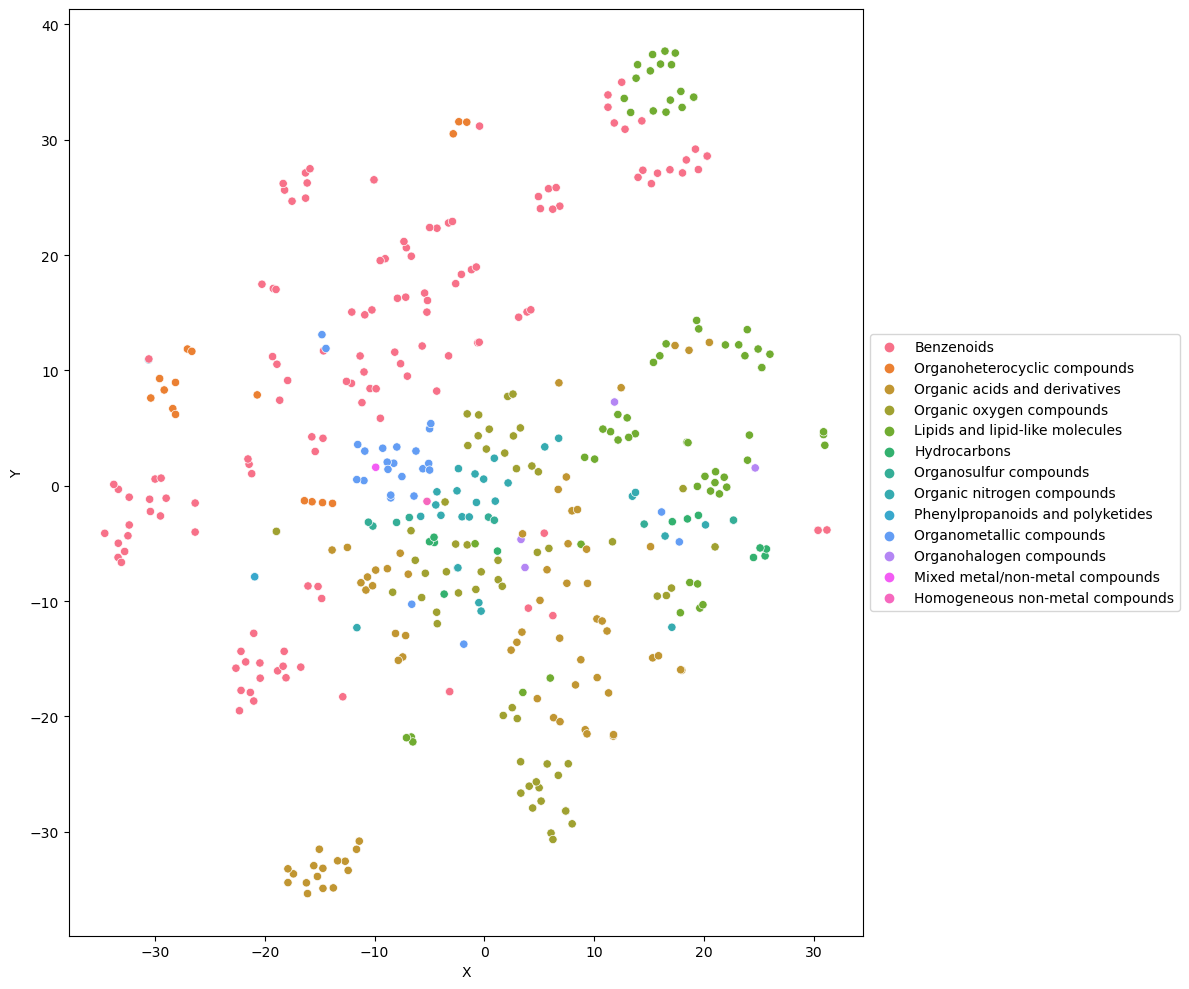

In [98]:
plt.figure(figsize = (12,10))
#color_dict = dict({1: 'red', 0: 'blue'})
ax = sns.scatterplot(x = 'X', y = 'Y' ,   hue = 'superclass', data = tsne_df2 )
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(figures_dir+'tsne_df.png', dpi = 300)

Analogue Evidence streams


Extracted the first evidence stream from all those noted in the dataset, across the 82 examples - there were 85 evidence streams - of these the majority of initial means of identifying candidate analogues were by structural considerations - in only 4 cases was Metabolism the first consideration

In [60]:
#set(df['Analogue Evidence Stream'])

In [141]:
len([e for e in list(set([str(e).split('|')[0].strip() for e in df['Analogue Evidence Stream']])) if 'Structural' in e])

72

In [142]:
[e for e in list(set([str(e).split('|')[0].strip() for e in df['Analogue Evidence Stream']])) if 'Stuctural' in e]

[]

In [143]:
len([e for e in list(set([str(e).split('|')[0].strip() for e in df['Analogue Evidence Stream']])) if 'Metab' in e])

4

In [145]:
len([e for e in list(set([str(e).split('|')[0] .strip() for e in df['Analogue Evidence Stream']]))])

77

In [146]:
structural_tags = [e.replace('Structural_', '')  for e in list(set([str(e).split('|')[0].strip() for e in df['Analogue Evidence Stream']])) if 'Structural_' in e]


In [149]:
structural_tags = [e.strip() for e in structural_tags]

In [150]:
structural_tags

['dimethyltin-moiety',
 'OECD-Toolbox_diphenylamine-core_dialkylated-substitutions',
 'oligomer-mixtures-of-alkyl-phenols-or-phenates',
 'common-functional-groups_isomers',
 'SciFinder_ChemID_close-similarity',
 'C1-C8-alkyl-esters-of-methacrylic-acid',
 'ChemIDPlus_alkylbenzenes_similar-straight-chain-structure',
 'common-functional-group_short-chain-length',
 'repeating-units_common-functional-group',
 'hydrolysis-pair',
 'RDKit_aliphatic-carboxylic-acids_same-position-branched-alkyl-side-chains',
 'DSSTox_OECD Toolbox-Tanimoto_ChemIDplus_functional-group-aldehyde',
 'Open-Babel-toolbox-Tanimoto_common-functional-groups',
 'OECD-Toolbox_diphenylamine-core',
 'common-general-molecular-structure',
 'common-functional-groups',
 'chlorosilanes_reactive-chlorine-groups',
 'ChemIDPlus',
 'simple-straight-chain-configuration',
 'silanol_similar-structure-to-target-hydrolysis-product',
 'OECD Toolbox_ChemIDPlus',
 'repeating-units_common-functional-groups',
 'CHRIP_OECD-Toolbox_common-phenol

Creating a simple mapping dict to summarise the types of structural flags/tools/approaches used

In [152]:
structural_tags_dict = {'OECD-Toolbox_diphenylamine-core_dialkylated-substitutions' : 'OECD-Toolbox',
 'C1-C8-alkyl-esters-of-methacrylic-acid' : 'common-functional-groups',
 'acid-dissociation': 'Other',
             'shared-4-ring-structure_similar-molecular-weight': 'common-functional-groups',           
                'high-molecular-weight-aliphatic-thiols_common-functional-group' : 'common-functional-groups',        
                        'common-functional-group': 'common-functional-groups',
                        'common-reactive-ester-bond_similar-alkyl-side-chains':'common-functional-groups' ,
                        
                   'common-functional-groups_structurally-similar-to-target-hydrolysis-product': 'common-functional-groups',
 'reactive-chlorine-group': 'common-functional-groups',
 'C2-C4-aliphatic-thiols_common-functional-group' :  'common-functional-groups',   
       'common-reactive-moiety_low-molecular-weight': 'common-functional-groups',
 'common-moieties': 'common-functional-groups',
 'common-reactive-functional-group': 'common-functional-groups',
 'common-general-molecular-structure': 'common-functional-groups',
 'chlorosilanes_reactive-chlorine-groups':'common-functional-groups' ,
 'common-polar-constituent-and-olefin-moiety': 'common-functional-groups',
 'common-functional-groups_reactive-chlorine-groups':'common-functional-groups' ,
 'common-functional-group-formate': 'common-functional-groups',                 
   'common-functional-groups_similar-2D-structure': 'common-functional-groups',                     
        'simple-straight-chain-configuration': 'common-functional-groups',
 'silanol_similar-structure-to-target-hydrolysis-product': 'common-functional-groups',                
               'dimethyltin-moiety': 'common-functional-groups' ,
 'common-functional-groups_isomers':'common-functional-groups',     
                        'common-functional-group_short-chain-length':'common-functional-groups',
 'repeating-units_common-functional-group' :'common-functional-groups',
                        'repeating-units_common-functional-groups': 'common-functional-groups',
                        'variable-alkyl-chain': 'common-functional-groups',
                        
                        
 'salts-of-same-parent-compound': 'Other',
 'dinitrobenzene-isomers' :'common-functional-groups',
 'ChemIDPlus': 'ChemIDPlus',
 'ChemIDplus_OECD Toolbox-Tanimoto_highest-structural-similarity':'OECD-Toolbox-ChemIDPlus',
 'DSSTox_ChemIDPlus':'DSSTox-ChemIDPlus',
 'common-functional-groups' : 'common-functional-groups',
 'SciFinder_ChemID_close-similarity':'Scifinder-ChemIDPlus',
 'ChemIDPlus_Chemical-Class_dinitrophenols':'ChemIDPlus',
 'ChemIDPlus_alkylbenzenes': 'ChemIDPlus',
 'ChemIDPlus_Chemical-Class_brominated-benzenes':'ChemIDPlus',
 'C4-olefin-isomers': 'common-functional-groups',
 'OECD-Toolbox_diphenylamine-core_ variable-number-phenyl-substitutions':'OECD-Toolbox',
 'OECD Toolbox-Tanimoto':'OECD-Toolbox',
     'OECD-QSAR-Toolbox_Tanimoto': 'OECD-Toolbox',                   
 'acid-chlorides_reactive-chlorines':'common-functional-groups',
 'benzene-backbone_mono-substituted-phenols':'common-functional-groups',
 'C6-C14-aliphatic-chain-olefins':'common-functional-groups',
 'SciFinder_ChemID_close-similarity':'Scifinder-ChemIDPlus',
 'OECD-Toolbox_ diphenylamine-core_variable-number-alkyl-substitutions':'OECD-Toolbox',
 'hydrolysis-pair': 'Other',
                        'OECD-Toolbox_ diphenylamine-core_monoalkylated-substitution': 'OECD-Toolbox',
 'RDKit_2-branched-aliphatic-carboxylic-acids_comparable-chain-lengths':'common-functional-groups',
      'OECD-Toolbox_ diphenylamine-core_variable-number-alkyl-substitutions':'OECD-Toolbox',                   
            'OECD-Toolbox_diphenylamine-core_ variable-number-phenyl-substitutions':'OECD-Toolbox',            
                    'ChemIDplus_OECD Toolbox-Tanimoto_highest-structural-similarity':'OECD-Toolbox-ChemIDPlus',    
              
        'DSSTox_ChemIDPlus_similar-branched-structure':'DSSTox-ChemIDPlus',                
           'ChemIDPlus_alkylbenzenes_similar-straight-chain-structure':   'ChemIDPlus',           
             'OECD Toolbox_ChemIDPlus':   'OECD-Toolbox-ChemIDPlus',         
                      'OECD-Toolbox-Tanimoto_ChemIDPlus_DSSTox_highest-structural-similarity': 'DSSTox-ChemIDPlus-OECD-Toolbox',  
 'OECD-Toolbox_diphenylamine-core':'OECD-Toolbox',
 'ChemIDPlus-OECD Toolbox':'OECD-Toolbox-ChemIDPlus',
 'shared-4-ring-structure_similar-molecular-weight':'common-functional-groups',
 'common-functional-group-peroxy':'common-functional-groups',
 'ChemTunes-ToxGPS_common-alkyl-substituents':'ChemTunes-ToxGPS',
 'oligomer-mixtures-of-alkyl-phenols-or-phenates':'common-functional-groups',
 'DSSTox_OECD Toolbox-Tanimoto_ChemIDplus_functional-group-aldehyde':'DSSTox-ChemIDPlus-OECD-Toolbox',
 'DSSTox_ChemIDPlus': 'DSSTox-ChemIDPlus',
 'ChemIDPlus':'ChemIDPlus',
 'OECD-Toolbox_ diphenylamine-core_monoalkylated-substitution':'OECD-Toolbox',
 'DSSTox_OECD Toolbox-Tanimoto_ChemIDplus_functional-group-aldehyde_closest-in-carbon-chain-length':'DSSTox-ChemIDPlus-OECD-Toolbox',
 'RDKit_aliphatic-carboxylic-acids_same-position-branched-alkyl-side-chains':'common-functional-groups',
 'KNIME_RDKIT_SMARTS_common-toxophore_similar-3D-structure' :'common-functional-groups' ,
 'OECD Toolbox_ChemIDPlus':'OECD-Toolbox-ChemIDPlus',
 'common-reactive-ester-bond_similar-alkyl-side-chains':'common-functional-groups',
 'common-functional-groups_similar-2D-structure':'common-functional-groups',
 'common-functional-group-formate':'common-functional-groups',
 'OECD Toolbox-Tanimoto' : 'OECD-Toolbox',
 'dibutyltin-moiety':'common-functional-groups',
 'DSSTox_ChemIDPlus_similar-branched-structure': 'DSSTox-ChemIDPlus',
 'variable-alkyl-chain':'common-functional-groups',
 'OECD-Toolbox-Tanimoto_ChemIDPlus_DSSTox' : 'DSSTox-ChemIDPlus-OECD-Toolbox',
 'Open-Babel-toolbox-Tanimoto_common-functional-groups': 'Open-Babel',
 'common-functional-group':'common-functional-groups',
 'common-functional-groups':'common-functional-groups',
 'simple-straight-chain-configuration':'common-functional-groups',
 'OECD-Toolbox-Tanimoto_ChemIDPlus_DSSTox_highest-structural-similarity':'DSSTox-ChemIDPlus-OECD-Toolbox',
 'Leadscope_ChemID_expert_judgement': 'Leadscope-ChemIDPlus',
 'ChemIDPlus_alkylbenzenes_similar-straight-chain-structure': 'ChemIDPlus',
 'CHRIP_OECD-Toolbox_common-phenolic-group-at-same-position-on-benzotriazole':'OECD-Toolbox' ,
 'OECD-QSAR-Toolbox_Tanimoto':'OECD-Toolbox',
 'chlorosilanes_reactive-chlorine-groups':'common-functional-groups',
 'ChemIDPlus_OECD-Toolbox-Tanimoto':'OECD-Toolbox-ChemIDPlus',
 'OECD-Toolbox-Tanimoto_ChemIDPlus_DSSTox':'DSSTox-ChemIDPlus-OECD-Toolbox',
 'CHRIP_visual-judgement_single-allyl-alcohol-group': 'Other',
 'common-polar-constituent-and-olefin-moiety':'common-functional-groups',
 'DSSTox':  'DSSTox',
                        'ChemTunes-ToxGPS_common-alkyl-substituents': 'ChemTunes-ToxGPS',       
 'ChemTunes-ToxGPS_Tanimoto_common-functional-groups': 'ChemTunes-ToxGPS',
 'MACCS-TANIMOTO_common-substituents': 'Other',
 'ChemMine-tools_MCS-Tanimoto': 'ChemMine'}

In [153]:
mylst = []
for k,v in structural_tags_dict.items():
    mylst.append(v)

In [154]:
len(set(mylst))

13

In [155]:
structural_tags_df = pd.DataFrame(list(structural_tags_dict.items()), columns = ['Struct-AE', 'Level1-Struct-AE'])

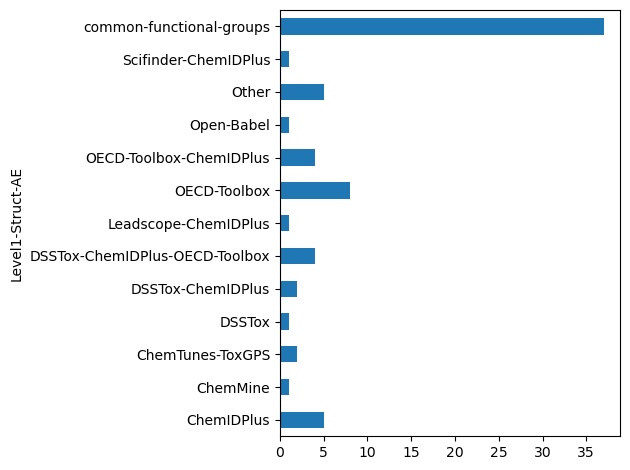

In [159]:
structural_tags_df.groupby('Level1-Struct-AE').size().plot.barh()
plt.tight_layout()
plt.savefig(figures_dir+'analogue_stream.png', dpi = 300)

## Structural similarity within the read-across cases

In [70]:
mydict = {}
for i, group in df1.groupby('Index'):
    subset = group[['DTXSID', 'Index', 'SMILES']]
    try:
        a = mk_fp(subset)
        b = distance_matrix(a)
        b1 = 1 - b
        mk = np.triu(np.ones(b1.shape), k=0)
        b2 = b1.where(mk==1, np.nan).unstack().reset_index().dropna()
        b2 = b2[b2['level_0'] != b2['level_1']]
        b2 = b2.iloc[:,2].values
        mydict[i] = b2
    except Exception as error:
        print(i, error)


40 No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
41 No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
47 No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
50 No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
54 No registered converter was able to produce a C++ rvalue of type std::basic_string<wchar_t, std::char_traits<wchar_t>, std::allocator<wchar_t> > from this Python object of type float
55 No registered converter was able to produce a C++ rvalue of type st

In [78]:
#mydict


In [71]:
new_df = pd.DataFrame({k:v for k,v in mydict.items() if len(v) >1}.items())
new_df['meds'] = [np.median(e) for e in new_df[1]]
new_df = new_df.sort_values(by = 'meds', ascending = False)

In [72]:
new_df['meds'].median()

0.3367730496453901

In [74]:
#new_df

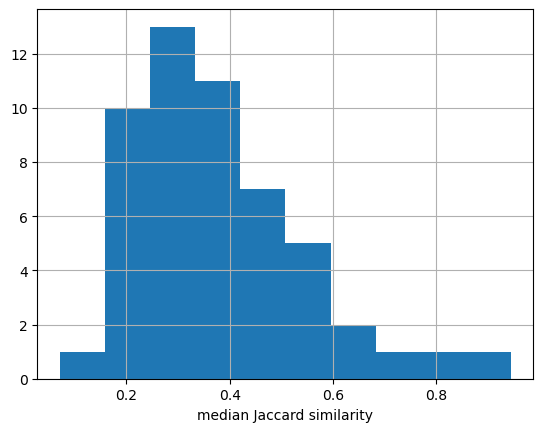

In [233]:
new_df['meds'].hist()
plt.xlabel('median Jaccard similarity')
plt.savefig(figures_dir+'median_JS_dist.png', dpi = 300)

In [75]:
labels, data = list(zip((new_df[0].values, new_df[1].values)))


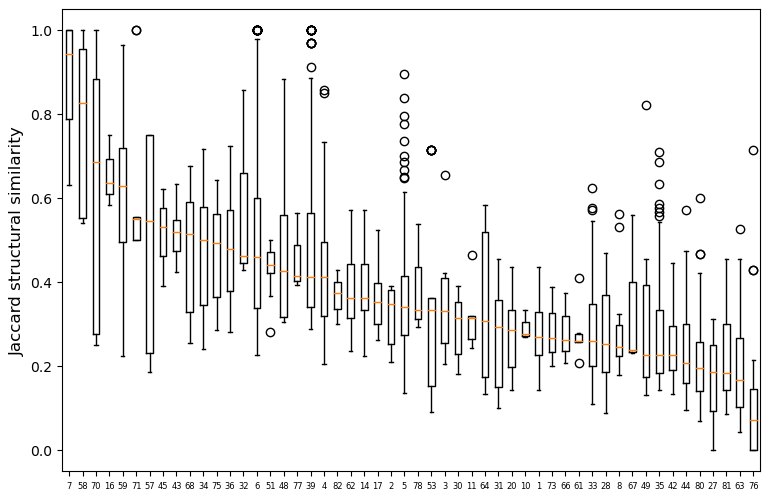

In [76]:
fig, ax = plt.subplots(figsize = (9,6))
labels, data = list(zip((new_df[0].values, new_df[1].values)))
ax.boxplot(data[0], vert=True)  # Set vert=True to flip the axis

# Set x-axis ticks and labels
plt.xticks(range(1, len(labels[0]) + 1), labels[0], fontsize=6)
plt.ylabel('Jaccard structural similarity', fontsize = 12)
fig.savefig(figures_dir+'Jaccard_SS.png', dpi = 300)

In [229]:
#mydict